## Create the environment, the buffer and the VAE

Create the model.

In [25]:
from stable_baselines3 import DQN

model = DQN("MlpPolicy", "PrivateEye-v4", buffer_size=100_000, learning_starts=1_000, verbose=1)

Using cuda device
Creating environment from the given name 'PrivateEye-v4'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [26]:
from go_explore.vae import CNNCategoricalVAE
from go_explore.categorical_go_explore import VAELearner

vae = CNNCategoricalVAE(nb_classes=2, nb_categoricals=24).to(model.device)
model.learn(50_000, callback=VAELearner(vae, model.replay_buffer, train_freq=1000))

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.6e+03  |
|    ep_rew_mean      | 250      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 296      |
|    time_elapsed     | 48       |
|    total_timesteps  | 14407    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000412 |
|    n_updates        | 3351     |
| vae/                |          |
|    kl_loss          | 0.0752   |
|    recons_loss      | 0.00967  |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.59e+03 |
|    ep_rew_mean      | -375     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 287      |
|    time_elapsed     | 99       |
|    total_timesteps  | 28726    |
| train/            

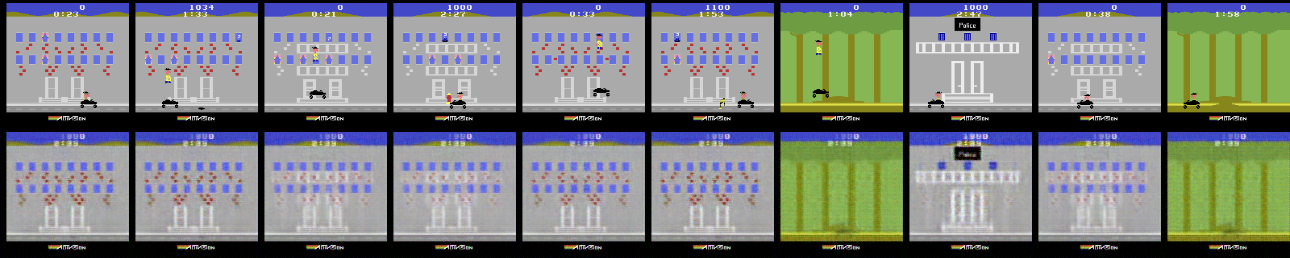

In [27]:
from go_explore.utils import build_image
from torchvision.transforms.functional import resize

input = model.replay_buffer.sample(10).observations
input = resize(input, (129, 129)).float() / 255
vae.eval()
recons, logits = vae(input)
build_image([input, recons])

Try cell factory associated.

In [28]:
from go_explore.categorical_go_explore import CNNCategoricalVAECelling

cell_factory = CNNCategoricalVAECelling(vae)

In [42]:
input = model.replay_buffer.sample(1000).observations
cells = cell_factory(input)

The goal here is to find observations that share the same cell, and show that they are very similar without behing equal.

In [43]:
import torch

_, inverse, counts = torch.unique(cells, return_inverse=True, return_counts=True, dim=0)
# print(unique, counts)
# inverse : input -> uid
# counts : uid -> counts

# I want cell where counts>1
not_unique_uids = torch.where(counts > 1)[0]
first_not_unique = [torch.where(not_unique_uids[i] == inverse)[0] for i in range(10)]
first_row = [input[f[0]] / 255 for f in first_not_unique]
first_row = torch.stack(first_row)
second_row = [input[f[1]] / 255 for f in first_not_unique]
second_row = torch.stack(second_row)

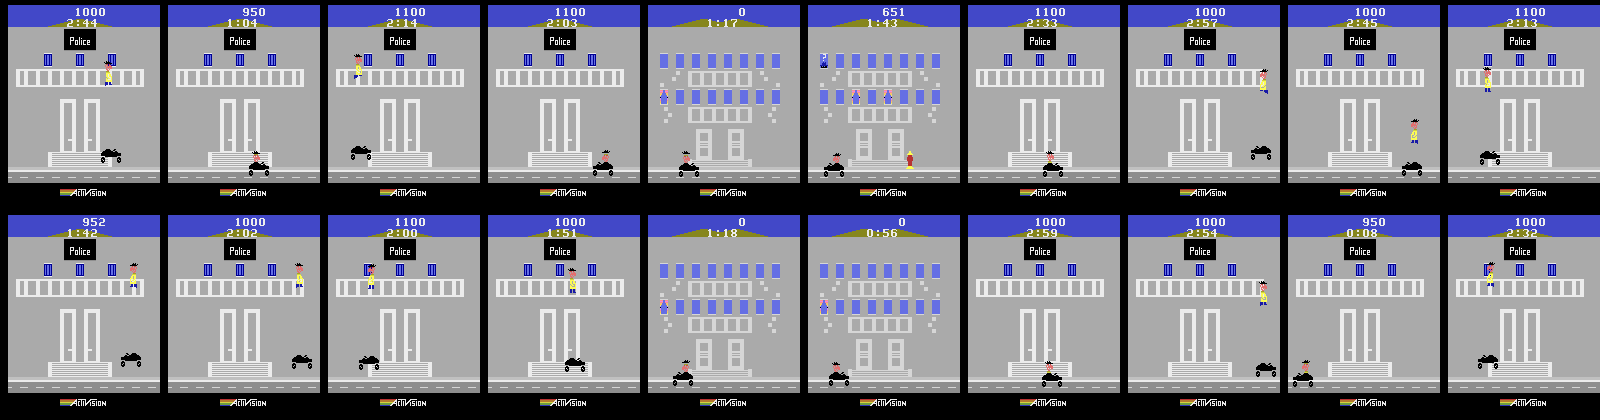

In [45]:
build_image([first_row, second_row])

In [36]:
from torch.nn.functional import one_hot

x = torch.randint(vae.nb_classes, size=(100, vae.nb_categoricals)).to(model.device)

torch.Size([100, 240])

Show the outputs.

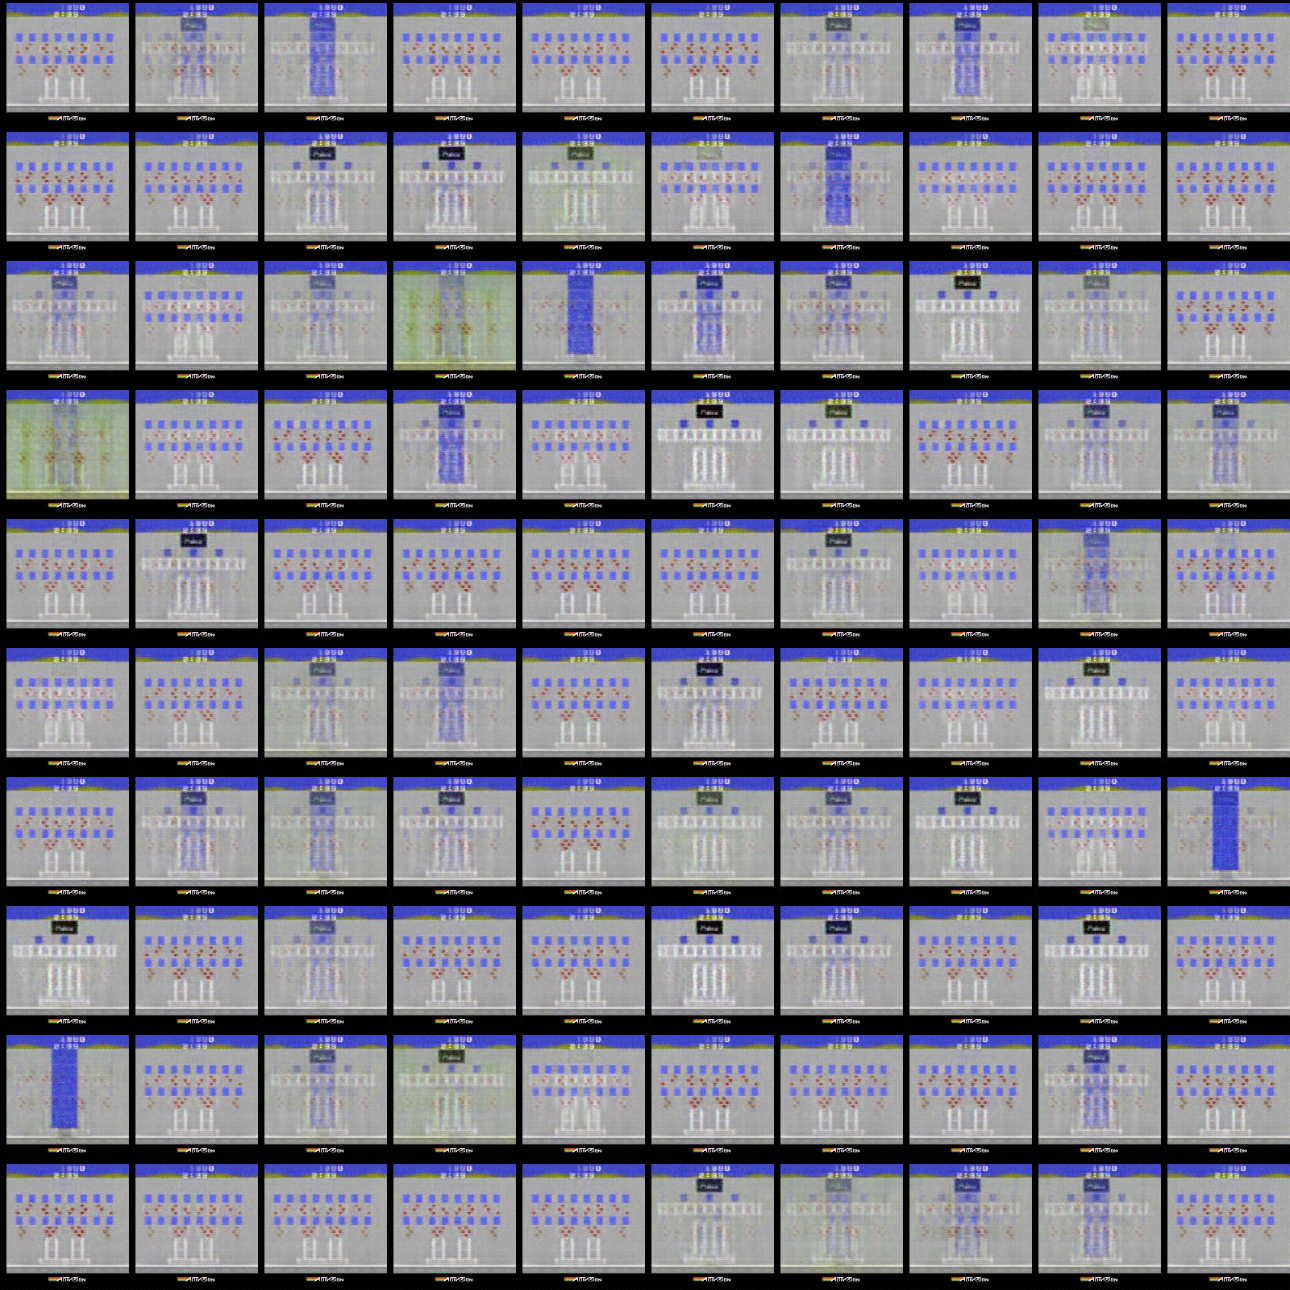

In [38]:
latent = one_hot(x, vae.nb_classes).flatten(1).float()
recons = vae.decoder(latent)

build_image([recons[10 * i : 10 * (i + 1)] for i in range(10)])